In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

def run_algorithm_multi_client(lambda_, delta, n_rounds, noise_variance, m):
    d = 10
    V0 = lambda_ * np.eye(d)
    theta0 = np.zeros(d)
    mu_q = np.zeros(d)
    C_q = np.eye(d)
    C = np.eye(d)

    def generate_decision_set(d, num_actions=1000):
        actions = np.random.randn(num_actions, d)
        actions = actions / np.linalg.norm(actions, axis=1, keepdims=True)
        return actions

    mu = np.random.multivariate_normal(mu_q, C_q)
    thetas = [np.random.multivariate_normal(mu, C) for _ in range(m)]
    print(f"thetas:", thetas)
    At = generate_decision_set(d)
    optimal_reward_list = [] 
    for client in range (m):
        optimal_reward = max(At.dot(thetas[client]))
        optimal_reward_list.append(optimal_reward)
        print (client, " ", optimal_reward)

    def compute_beta_t(d, m, delta, sigma, T,lambda_min_C,lambda_max_C,lambda_max_Cq):
        term1 = (
            1 / lambda_min_C * (1 + 1 / m + sigma**-2 * lambda_min_C) + sigma**2 / m * T
        ) ** 0.5
        term2 = (sigma**2 + lambda_max_C) ** 2 / (m**2 * lambda_max_Cq) + m * (
            sigma**2 + lambda_max_C
        )
        term3 = (m / (lambda_min_C + (sigma**2 / T))) * np.sqrt(
            2 * d * sigma**2 + 8 * sigma**2 * np.log(2 * m * T / delta)
        )
        gamma1 = term1 * term2 * term3
        gamma2 = (
            1 / lambda_min_C * (1 + 1 / m + sigma**-2 * lambda_min_C) + sigma**2 / m * T
        ) ** 0.5
        gamma2 *= (
            (sigma**2 + lambda_max_C)
            / (m + (sigma**2 + lambda_max_C) * 1/lambda_max_Cq)
            * lambda_max_Cq
            * np.linalg.norm(mu_q)
        )
        beta_t = gamma1 + gamma2 + np.sqrt(2 * d + 8 * np.log(2 * m * T / delta))
        return beta_t
    
    def compute_C_hat(C_inv, Gi_t, C_bar_t):
        C_tilde = np.linalg.inv(C_inv + Gi_t)
        C_hat = C_tilde + C_tilde @ C_inv @ C_bar_t @ C_inv @ C_tilde
        return C_hat

    def compute_mut_t(G_inv_list, bi_t_list, C_bar_t,t):
        sum_term = np.zeros((d, 1))
        for Gi_t_inv, bi_t in zip(G_inv_list, bi_t_list):
            term1 = np.linalg.inv(C + Gi_t_inv)
            sum_term += np.matmul(Gi_t_inv, bi_t)
        mu_t = C_bar_t @ sum_term
        mu_t = mu_t.flatten()  # Ensure mu_t has the correct shape
        return mu_t
        
    def compute_confidence_set_center(mu_t, C_inv, Gi_t, bi_t):
        return np.linalg.inv(C_inv + Gi_t) @ (C_inv @ mu_t + bi_t)

    lambda_min_C = np.linalg.eigvals(C).min()
    lambda_max_C = np.linalg.eigvals(C).max()
    lambda_max_Cq = np.linalg.eigvals(C_q).max()
    Gi_t = [np.zeros((d,d)) for _ in range(m)] 
    bi_t = [np.zeros(d).reshape((10,1)) for _ in range(m)] 
    C_bar_t = np.eye(d)
    C_hat = [np.zeros((d,d)) for _ in range(m)]
    confidence_set_center = [np.zeros(d).reshape((10,1)) for _ in range(m)] 
    all_regrets = [[] for _ in range(m)]
    regret_per_trial = [[] for _ in range(m)]
    distances_to_true_theta = [[] for _ in range(m)] 
    beta_t = compute_beta_t(
                d,
                m,
                delta,
                np.sqrt(noise_variance),
                n_rounds,
                lambda_min_C,
                lambda_max_C,
                lambda_max_Cq,
            )
    for t in range(1, n_rounds + 1):     
        G_inv_list = []  
        bi_t_list = [] 
        sum_C_inv_plus_Gi_t_inv = np.zeros((d, d))
        for client in range(m):
            Vt = V0
            theta_t = theta0
            total_possible_reward = 0
            total_reward = 0
            #regrets = []
            if t <= d:
                At = [np.eye(d)[:, t-1]] 
            else:
                At = generate_decision_set(d)
            #At = generate_decision_set(d)
            if t<= d:
                At_selected = At[0]
            else: 
                ucb_values = [
                    confidence_set_center[client].T @ (a.reshape((d,1))) 
                    + beta_t * np.sqrt(a.reshape((1,d)) @ (np.linalg.inv(C_hat[client])) @ a.reshape((d,1)))
                    for a in At
                ]
                max_index = np.argmax(ucb_values)
                At_selected = At[max_index]
            Xt = At_selected.dot(thetas[client]) # + np.random.randn() * np.sqrt( noise_variance )
            #optimal_reward = max(At.dot(thetas[client]))
            total_possible_reward += optimal_reward_list[client]
            total_reward += Xt
            regret = max (0, optimal_reward_list[client] - Xt)
            # Print to check each round's results
            # print(f"Round {t}, Client {client+1}:")
            # print(f"  Selected action: {At_selected}")
            # print(f"  Observed reward: {Xt}")
            # print(f"  Instantaneous regret: {regret}\n")
            all_regrets[client].append(regret)
            #Gi_t[client] += 1/ noise_variance * np.outer(At_selected, At_selected)
            Gi_t[client] = V0 + sum(np.outer(At_selected, At_selected) for _ in range(t))/ noise_variance
            bi_t[client] += 1 / noise_variance * At_selected.reshape((10,1)) * Xt 
            if t >= d:
                Gi_t_inv = np.linalg.inv(Gi_t[client]) 
                G_inv_list.append(Gi_t_inv)
                bi_t_list.append(bi_t[client])
                sum_C_inv_plus_Gi_t_inv += np.linalg.inv(C + Gi_t_inv)
                #print(f"Trial {t}, Client {client+1}: = Regret: {regret}")
        if t >= d: 
            C_bar_t = np.linalg.inv(sum_C_inv_plus_Gi_t_inv)
            for client in range(m):
                C_inv = np.linalg.inv(C)
                mu_t = compute_mut_t(G_inv_list, bi_t_list, C_bar_t, t).reshape((10,1))
                confidence_set_center[client] = compute_confidence_set_center(mu_t, C_inv, G_inv_list[client], bi_t_list[client])
                C_hat[client] = compute_C_hat(C_inv, G_inv_list[client], C_bar_t)
                distance = np.linalg.norm(confidence_set_center[client] - thetas[client])
                distances_to_true_theta[client].append(distance)
    for client in range(m):
        all_regrets[client] = np.cumsum(all_regrets[client]) 
        regret_per_trial[client] = all_regrets[client]/np.arange(1, n_rounds + 1)
    return all_regrets, regret_per_trial, distances_to_true_theta

thetas: [array([ 0.0995448 , -1.39379168,  1.21045091, -0.29515412, -1.32275919,
        0.36051717, -1.51814443, -0.83479196,  2.51778835, -1.60155599]), array([ 0.41512633,  1.07957998,  1.94105552, -0.65020411, -1.25838024,
       -1.0763997 , -3.0827948 ,  2.03648282,  0.28718638,  1.42891086])]
0   3.302737915791211
1   4.291133030010532


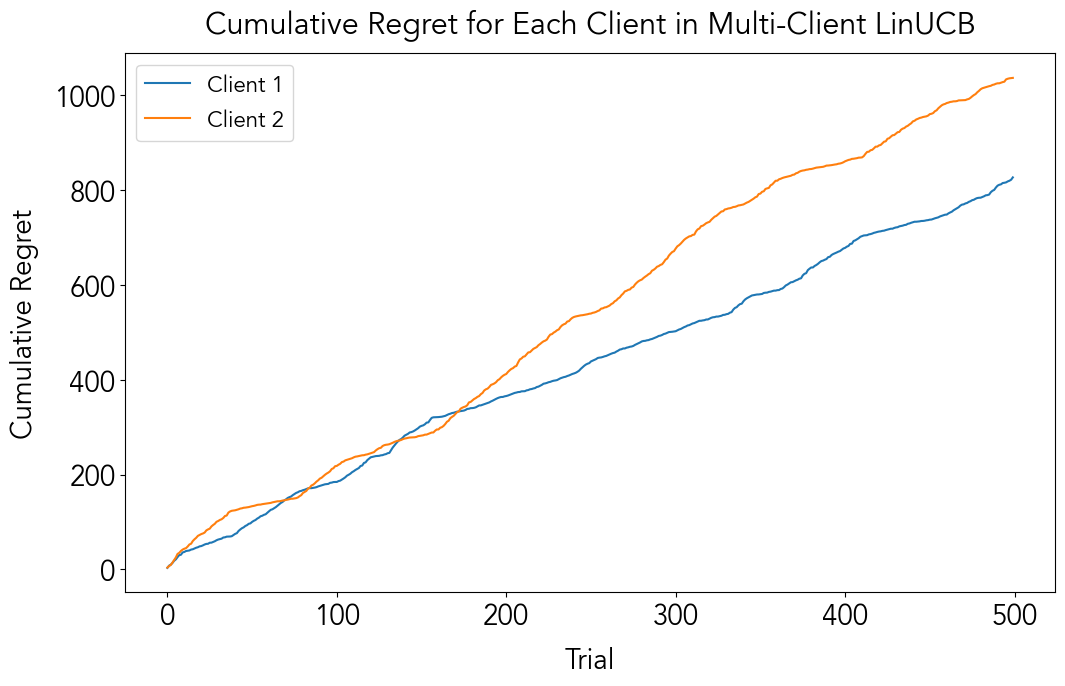

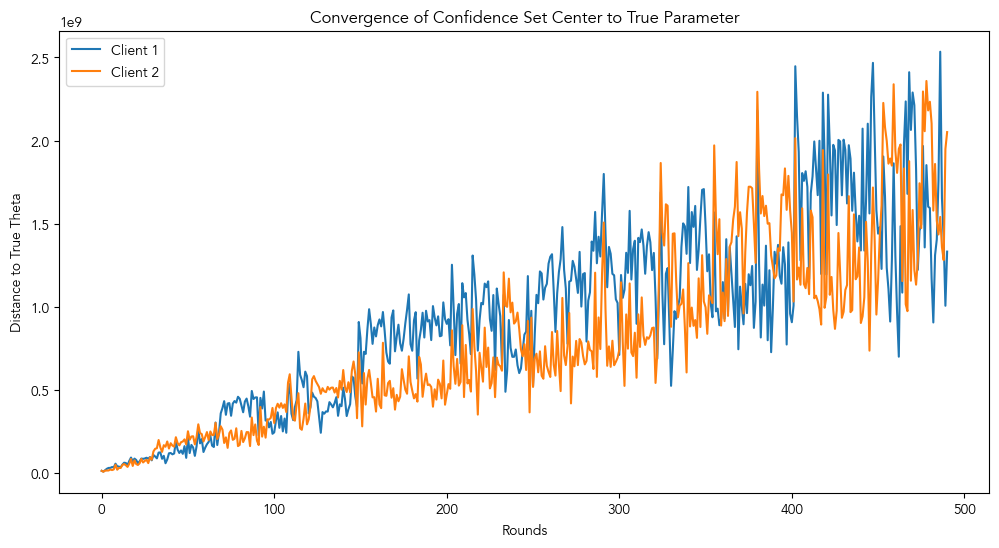

In [27]:
#average
lambda_ = 0.01
delta = 0.0001
n_rounds = 500
noise_variance = 0.0001
m = 2  # Number of clients

all_regrets, regret_per_trial, distances_to_true_theta = run_algorithm_multi_client(lambda_, delta, n_rounds, noise_variance, m)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Avenir'  
plt.rcParams['font.monospace'] = 'Avenir Mono'

# # average
# plt.figure(figsize=(12,7))
# for i, client_regret in enumerate(regret_per_trial):
#     #regret_per_trial = client_regret / np.arange(1, n_rounds + 1)
#     plt.plot(client_regret, label=f"Client {i+1}")

# plt.xlabel("Trial",fontsize=20, labelpad =10)
# plt.ylabel("Average Regret per Trial",fontsize =20, labelpad=10)
# #plt.title("Average Regret per Trial for Each Client in Multi-Client LinUCB",pad = 15 ,fontsize= 18)
# plt.title("Average Regret per Trial for Each Client in Multi-Client LinUCB",pad = 15 ,fontsize= 22)
# plt.legend(fontsize=16)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.show()

# cumulative
plt.figure(figsize=(12, 7))
for i, cumulative_regret in enumerate(all_regrets):
    plt.plot(cumulative_regret, label=f"Client {i+1}")

plt.xlabel("Trial",fontsize=20, labelpad =10)
plt.ylabel("Cumulative Regret", fontsize=20, labelpad =10)
plt.title("Cumulative Regret for Each Client in Multi-Client LinUCB", pad = 15 ,fontsize= 22)
plt.legend(fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


# Plot the distances to see convergence
plt.figure(figsize=(12, 6))
for client in range(m):
    plt.plot(distances_to_true_theta[client], label=f'Client {client+1}')
plt.xlabel('Rounds')
plt.ylabel('Distance to True Theta')
plt.title('Convergence of Confidence Set Center to True Parameter')
plt.legend()
plt.show()

In [23]:
#table 
lambda_ = 0.01
delta = 0.0001
n_rounds = 1000
noise_variance = 0.001
m = 1  # Number of clients

# Run the multi-client algorithm
all_regrets, regret_per_trial = run_algorithm_multi_client(lambda_, delta, n_rounds, noise_variance, m)

# Select intervals for displaying regrets
interval = 10
iterations = list(range(1, n_rounds + 1, interval))
regrets_at_intervals = np.array([regrets[::interval] for regrets in all_regrets])

# Prepare cumulative regret for display at intervals
cumulative_regret_at_intervals = regrets_at_intervals.cumsum(axis=1)

# Create a DataFrame to display results at each interval for each client
data = {
    'Iteration': iterations,
    'Cumulative Regret (Client 1)': cumulative_regret_at_intervals[0],
}
df = pd.DataFrame(data)
# Display the DataFrame
display(df)

data_per_trial = {
    'Iteration': list(range(1, n_rounds + 1)),
    'Regret per Trial (Client 1)': regret_per_trial[0],
}
df_per_trial = pd.DataFrame(data_per_trial)

# Display the DataFrame
print(df_per_trial)

thetas: [array([-2.96564236, -0.2444705 ,  0.34878433, -2.63008295,  2.10306774,
        1.36043907, -2.35459327, -1.20806676, -1.33733325,  2.18386118])]
0   4.799928745746205


,Iteration,Cumulative Regret (Client 1)
0,1,7.765571
1,11,60.508895
2,21,125.119643
3,31,199.694900
4,41,284.968101
...,...,...
95,951,53801.386729
96,961,54900.118668
97,971,56007.628934
98,981,57127.046184


     Iteration  Regret per Trial (Client 1)
0            1                     7.765571
1            2                     6.404985
2            3                     5.753705
3            4                     6.172782
4            5                     5.477597
..         ...                          ...
995        996                     1.139536
996        997                     1.138792
997        998                     1.139045
998        999                     1.137972
999       1000                     1.137031

[1000 rows x 2 columns]


thetas: [array([-1.30537373,  2.00617007,  1.01756671, -2.58766192,  0.34558454,
       -0.13554556,  1.36731942,  0.01520671,  1.633133  ,  1.05055548]), array([-2.94474546,  1.89047729, -1.27684543, -0.24137847,  0.87278908,
       -0.79746263,  0.93560949,  0.64940797,  2.06422826,  1.35400236]), array([ 0.79685068,  1.87442496,  1.05689878, -1.06954479,  1.39194407,
        0.55258663, -0.13650388,  0.49465125,  0.00352062,  0.5120586 ]), array([-0.13664122,  1.74985105,  0.65765737, -4.56744226,  0.11723255,
        0.44621161,  1.62156456,  0.03620941,  1.86960944,  1.59103963]), array([-0.1295958 ,  0.92676273,  1.01610496, -2.43053068,  0.04469348,
       -0.10871867,  2.46749083,  1.44154685,  1.96883813,  1.27860979])]
0   3.6498935529199006
1   4.090736870445055
2   2.8136818824240755
3   4.747024173915377
4   4.0671064547878535


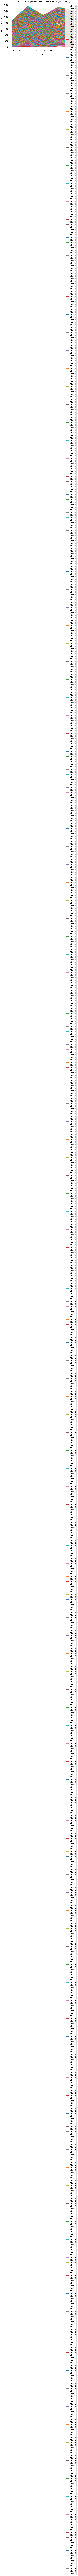

In [24]:
#cumulative 
lambda_ = 0.01
delta = 0.0001
n_rounds = 500
noise_variance = 0.001
m = 5  # Number of clients

    
all_regrets = run_algorithm_multi_client(lambda_, delta, n_rounds, noise_variance, m)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Avenir'  # Replace with a more common font
plt.rcParams['font.monospace'] = 'Avenir Mono'
# Plot cumulative regret for each client
plt.figure(figsize=(12, 8))
for i, cumulative_regret in enumerate(all_regrets):
    plt.plot(cumulative_regret, label=f"Client {i+1}")

plt.xlabel("Trial",fontsize=20, labelpad =10)
plt.ylabel("Cumulative Regret", fontsize=20, labelpad =10)
plt.title("Cumulative Regret for Each Client in Multi-Client LinUCB", pad = 15 ,fontsize= 22)
plt.legend(fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()